# Introduction To TimeSeriesDataFrames

The core data structure of the Azure ML Package for Forecasting is the `TimeSeriesDataFrame`.  In this notebook, you will learn about this class and it's children the `ForecastDataFrame` and the `MultiForecastDataFrame`.  However, we expect that if you are using this notebook you are already familiar with the `TimeSeriesDataFrame`'s parent class, the `pandas.DataFrame`.  If you are not already familiar with `pandas.DataFrame`s and in particular `pandas.DataFrame`s with a `MultiIndex`, please check out our notebook titled '*Data wrangling with "Azure ML Package for Forecasting" data structures*'.

Let's start by importing our data structures. And then we can go over each class and see how they build on eachother.

In [1]:
import warnings
# Suppress warnings
warnings.filterwarnings("ignore") 
import pandas as pd
import matplotlib.pyplot as plt
from ftk import TimeSeriesDataFrame, ForecastDataFrame, MultiForecastDataFrame
from ftk.data import load_dominicks_oj_dataset
from ftk.models import Naive, SeasonalNaive, ForecasterUnion

## `TimeSeriesDataFrame`

The `TimeSeriesDataFrame` is a `pandas.DataFrame` with additional metadata, properties, and functions to provide time series specific functionality. It uses [hierarchical indexing through MultiIndexes](https://pandas.pydata.org/pandas-docs/stable/advanced.html) where more than one one column can be used as an index to provide some of this functionality.  For this notebook we will be working with a dataset of orange juice sales from a number of stores in the greater Chicago area.  We will begin by reading it in.

In [2]:
oj_data, oj_test = load_dominicks_oj_dataset()
oj_data.head()

,,,week,logmove,feat,price,AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5,Quantity,WeekFirstDay
WeekLastDay,store,brand,,,,,,,,,,,,,,,,,
1990-06-20 23:59:59,2,dominicks,40,9.26,1,1.59,0.23,0.25,0.11,10.55,0.10,0.30,0.46,2.11,1.14,1.93,0.38,10560,1990-06-14
1990-08-01 23:59:59,2,dominicks,46,8.99,0,2.69,0.23,0.25,0.11,10.55,0.10,0.30,0.46,2.11,1.14,1.93,0.38,8000,1990-07-26
1990-08-08 23:59:59,2,dominicks,47,8.83,1,2.09,0.23,0.25,0.11,10.55,0.10,0.30,0.46,2.11,1.14,1.93,0.38,6848,1990-08-02
1990-08-15 23:59:59,2,dominicks,48,7.97,0,2.09,0.23,0.25,0.11,10.55,0.10,0.30,0.46,2.11,1.14,1.93,0.38,2880,1990-08-09
1990-08-29 23:59:59,2,dominicks,50,7.38,0,2.09,0.23,0.25,0.11,10.55,0.10,0.30,0.46,2.11,1.14,1.93,0.38,1600,1990-08-23


### Metadata

Lets start by looking at our orange juice dataset and see what metadata fields it has.

In [3]:
print("{")
for m in oj_data._metadata:
    print("    {0}: {1}".format(m, getattr(oj_data, m)))
print("}")

{
    grain_colnames: ['store', 'brand']
    time_colname: WeekLastDay
    ts_value_colname: Quantity
    group_colnames: ['store', 'brand']
    origin_time_colname: None
}


We see our `TimeSeriesDataFrame` has 5 metadata fields:
* time_colname
* ts_value_colname
* grain_colnames
* group_colnames
* origin_time_colname

### `time_colname`

Since the definition of a time series is "a series of values of a quantity obtained at successive times" it seems reasonable that the first metadata field we need to look at is the `time_colname`.  This is the only required metadata field, you can't have a time series without time after all.

* `time_colname`: The name of the column storing the time point for the row of data.  The values stored in this column should be of a datetime type.

Let's try an example.  We will make a set of 4 months starting in January of 2017 create a value of our time series starting at 0 and increasing by one each month.  We will compare the results of turning the data into a `pandas.DataFrame` and a `TimeSeriesDataFrame`.

In [4]:
# Make example data
my_data = {'date': pd.date_range('2017-01-01', periods=4, freq = 'MS'),
           'value': list(range(0,4))}
# Create pandas.DataFrame
my_pddf = pd.DataFrame(my_data)
my_pddf

,date,value
0,2017-01-01,0
1,2017-02-01,1
2,2017-03-01,2
3,2017-04-01,3


In [5]:
# Create TimeSeriesDataFrame
my_tsdf = TimeSeriesDataFrame(my_data, time_colname='date')
my_tsdf

,value
date,
2017-01-01,0
2017-02-01,1
2017-03-01,2
2017-04-01,3


We see that the `TimeSeriesDataFrame` moved the `time_colname` to the index.  This provided a lot of [time related functionality](https://pandas.pydata.org/pandas-docs/stable/timeseries.html) available in `pandas` such as getting windows of your data.

`TimeSeriesDataFrame`s have additional checks to ensure that the time series data are properly formatted, such as making sure that each time point only occurs once in the data.

**Exercise**:  Compare the results of creating a data frame with a duplicated time index value in `pandas` vs in `ftk`.  Why would this check be important when making time series?

In [6]:
dup_data = {'date': [pd.to_datetime('2017-01-01')]*4,
           'value': list(range(0,4))}
pd.DataFrame({'value':dup_data['value']}, index = dup_data['date'])
### Uncomment below to run ##
# TimeSeriesDataFrame(dup_data, time_colname='date')

,value
2017-01-01,0
2017-01-01,1
2017-01-01,2
2017-01-01,3


### `ts_value_colname`

The next field we will look at is the `ts_value_colname`.  

* `ts_value_colname`: Name of the column containing the data we want to forecast, kind of like our target in machine learning.  

This is important because in data like the orange juice dataset we may have many additional columns that help provide features for the forecast and we need to be able to distinguish our target column from these features.  Once we have designated a `ts_value_colname` we can start fitting models.  Let's make `value` our `ts_value_colname` and fit a simple `Naive` model.

In [7]:
my_tsdf_value = TimeSeriesDataFrame(my_data, time_colname='date', ts_value_colname='value')
snaive_model = SeasonalNaive(freq = 'MS', seasonality=7)
snaive_model.fit(my_tsdf_value)

SeasonalNaive(freq='MS', seasonality={'__identity_grain': 1})

**Exercise**: Try running the cell above with `my_tsdf` instead of `my_tsdf_value`. Try the same thing with `oj_data`.  Which column of `oj_data` did it build the `Naive` model to forecast?

### `grain_colnames`

Our next metadata field is the `grain_colnames`.  This is the first meta data field we will look at where you can specify more than one column for the metadata field.

* `grain_colnames`: Name of the column or columns that specify unique time series.

A `TimeSeriesDataFrame` can hold more than one time series at a time, so for example, `oj_data` contains 249 different time series; 83 different stores and each store has 3 different brands of orange juice.

Lets try building our own `TimeSeriesDataFrame` with grains.

In [8]:
grain_data = {'date': list(pd.date_range('2017-01-01', periods=4, freq = 'MS'))*2,
              'grain': ['A']*4 + ['B']*4,
              'value': list(range(0,8))}
my_tsdf_grain = TimeSeriesDataFrame(grain_data, time_colname='date', 
                                    ts_value_colname='value', grain_colnames = 'grain')
my_tsdf_grain

,,value
date,grain,
2017-01-01,A,0
2017-02-01,A,1
2017-03-01,A,2
2017-04-01,A,3
2017-01-01,B,4
2017-02-01,B,5
2017-03-01,B,6
2017-04-01,B,7


Like the `time_colname`, the `grain_colname` gets moved to the index so it can help identify rows of our time series.

**Exercise**:  What happens in the cell above if we don't specify the `grain_colnames` parameter?  Why?  For a hint, try looking at the excercise for `time_colname`.

### `group_colnames`

`group_colnames` are similar to the idea of grain, but are related to modeling rather than identifying a single time series.

* `group_colnames`: designate columns whose unique values specify rows of the data that would benifit from being modeled together.  `RegressionForecaster` will create one model for each unique `group`.

By default `group_colnames` is the same as `grain_colnames`.

**Excercise**: Make it so all the grains of our `grain_data` will be modeled together by setting `group_colnames` to `None`.

In [9]:
print(my_tsdf_grain.group_colnames)
my_tsdf_no_group = TimeSeriesDataFrame(grain_data, time_colname='date', 
                                       ts_value_colname='value', 
                                       # group_colnames = ???,
                                       grain_colnames = 'grain')
print(my_tsdf_no_group.group_colnames)

['grain']
['grain']


**Exercise**: `oj_data` has the default setting currently where `grain` and `group` are the same.  Overwrite `group` to just be `brand`.

In [10]:
oj_group_brand = oj_data.copy()
print('oj_group_brand.grain_colnames = {0}'.format(oj_group_brand.grain_colnames))
print('oj_group_brand.group_colnames = {0}'.format(oj_group_brand.group_colnames))
# oj_group_brand.group.colnames = ???
print('oj_group_brand.grain_colnames = {0}'.format(oj_group_brand.grain_colnames))
print('oj_group_brand.group_colnames = {0}'.format(oj_group_brand.group_colnames))

oj_group_brand.grain_colnames = ['store', 'brand']
oj_group_brand.group_colnames = ['store', 'brand']
oj_group_brand.grain_colnames = ['store', 'brand']
oj_group_brand.group_colnames = ['store', 'brand']


### origin_time_colname

You can sucessfully use `ftk` from start to finish without ever directly interacting with the conceptually dense field of `origin_time`.  In the majority of cases, the users will not specify this column, instead it will be created for them by one of the featurizers.  A full discussion of `origin_time` will be left for the notebook '*Constructing Lags and Explaining Origin Times*'.  In brief, `origin_time` accounts for the fact that we have different knowledge and expectations of a forecast based on when that forecast is made, giving us different features and different forecasts. For example, when checking the weather forecast you probably have a higher expectation for the accuracy of tomorrow's forecast compared to if you got the forecast from 10 days earlier.  That is because meterologists know more about the climitological conditions the closer we get to the time we are forecasting.  If you have features that your are inputting into the `TimeSeriesDataFrame` constructor that you learn more about the closer you get to the time you are forecasting, then you will need to specify an `origin_time_colname`.  Otherwise, sit back and let the `ftk` featurizers worry about it for you.

* `origin_time_colname`:  The name of the column that tells you when you *collected* the features on that row of data.  In other words if this row is for a 10 day forecast, the `origin_time` will be 10 days before the `time_index`.

There is one special aspect of `origin_time` we should mention; the `ts_value` has to be the same across all `origin_time`s.  In other words, if we are making a 10 day forecast vs a 1 day forecast for a particular date, the features we use to make that forecast may change, but the actual value of the series (our target) will be the same.  The true temperature on June 23rd will not change just because we are trying to make the forecast on June 13th instead of June 22nd.

In [11]:
origin_data = {'date': list(pd.date_range('2017-03-01', periods=4, freq = 'MS'))*2,
               'origin': [pd.to_datetime('2017-01-01')]*4 + [pd.to_datetime('2017-02-01')]*4 ,
               'value': list(range(0,4))*2}
my_tsdf_origin = TimeSeriesDataFrame(origin_data, time_colname='date', 
                                     ts_value_colname='value', 
                                     origin_time_colname = 'origin')
my_tsdf_origin

,,value
date,origin,
2017-03-01,2017-01-01,0
2017-04-01,2017-01-01,1
2017-05-01,2017-01-01,2
2017-06-01,2017-01-01,3
2017-03-01,2017-02-01,0
2017-04-01,2017-02-01,1
2017-05-01,2017-02-01,2
2017-06-01,2017-02-01,3


Like `time_index` and `grain_colnames`, `origin_time` is part of the index for the dataset.

**Excercise**: What happens if we made the `value` column of `origin_data` `list(range(0,8))` instead?  Why does this happen?

`TimeSeriesDataFrame`s have an additional property `horizon` which tell you the time difference between the `time_index` and the `origin_time` for each row of data.  We can access the `horizon` as follows:

In [12]:
my_tsdf_origin.horizon

TimedeltaIndex([ '59 days',  '90 days', '120 days', '151 days',  '28 days',
                 '59 days',  '89 days', '120 days'],
               dtype='timedelta64[ns]', name='horizon', freq=None)

## `ForecastDataFrame`

While `TimeSeriesDataFrames` store the inputs to forecasting models, `ForecastDataFrames` hold the outputs.  To get an example of a `ForecastDataFrame` lets make a `SeasonalNaive` model and forecast our `oj_data`.

In [13]:
snaive_model = SeasonalNaive(freq = oj_data.infer_freq(), seasonality=7)
snaive_model.fit(oj_data)
oj_fcast = snaive_model.predict(oj_test)
oj_fcast.head()

,,,,week,logmove,feat,price,AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5,Quantity,WeekFirstDay,DistributionForecastSeasonalNaive,PointForecastSeasonalNaive
WeekLastDay,store,brand,ForecastOriginDate,,,,,,,,,,,,,,,,,,,
1992-01-08 23:59:59,2,dominicks,1992-01-01 23:59:59,121,9.37,0,1.69,0.23,0.25,0.11,10.55,0.10,0.30,0.46,2.11,1.14,1.93,0.38,11712,1992-01-02,<scipy.stats._distn_infrastructure.rv_frozen o...,6208.00
1992-01-15 23:59:59,2,dominicks,1992-01-01 23:59:59,122,8.30,0,1.76,0.23,0.25,0.11,10.55,0.10,0.30,0.46,2.11,1.14,1.93,0.38,4032,1992-01-09,<scipy.stats._distn_infrastructure.rv_frozen o...,3008.00
1992-01-22 23:59:59,2,dominicks,1992-01-01 23:59:59,123,8.75,0,1.82,0.23,0.25,0.11,10.55,0.10,0.30,0.46,2.11,1.14,1.93,0.38,6336,1992-01-16,<scipy.stats._distn_infrastructure.rv_frozen o...,19456.00
1992-01-29 23:59:59,2,dominicks,1992-01-01 23:59:59,124,9.52,0,1.47,0.23,0.25,0.11,10.55,0.10,0.30,0.46,2.11,1.14,1.93,0.38,13632,1992-01-23,<scipy.stats._distn_infrastructure.rv_frozen o...,16768.00
1992-02-05 23:59:59,2,dominicks,1992-01-01 23:59:59,125,10.72,0,1.29,0.23,0.25,0.11,10.55,0.10,0.30,0.46,2.11,1.14,1.93,0.38,45120,1992-01-30,<scipy.stats._distn_infrastructure.rv_frozen o...,13568.00


As we did with our `TimeSeriesDataFrame` lets take a look at our `ForecastDataFrame` and see what new metadata it has.

In [14]:
print("{")
for m in oj_fcast._metadata:
    print("    {0}: {1}".format(m, getattr(oj_fcast, m)))
print("}")

{
    grain_colnames: ['store', 'brand']
    time_colname: WeekLastDay
    group_colnames: ['store', 'brand']
    origin_time_colname: ForecastOriginDate
    actual: Quantity
    pred_point: PointForecastSeasonalNaive
    pred_dist: DistributionForecastSeasonalNaive
}


The first thing we note that even though `oj_data` didn't have an `origin_time_colname` specified, the `ForecastDataFrame` does.  This is because forecasts are always relative to when you are making them.  If when you made a forecast did not affect the value of the forecast, then you could think if it as just a standard regression.  Next we notice we have three new fields:

* `actual`
* `pred_point`
* `pred_dist`

Let's go through each of them.

### `actual`

`actual` is the `ForecastDataFrame`'s version of `ts_value_colname`.

* `actual`: the true value of the time series.

When making forecast into the future, the value of `actual` will be `None`, but when we are testing our models we can provide this column so we can compute errors.  For example, if we want to compute the Mean Absolute Percent Error (MAPE) for our models we can do the following:

In [15]:
oj_fcast.calc_error('MAPE')

118.15278704612007

**Excercise**: In the box above what would you change to calculate the Mean Absolute Saled Error (MASE) instead?

### `pred_point`

This is the defining property of the `ForecastDataFrame`.

* `pred_point`: The point forecast value for the series.

In a package like `scikit-learn` calling `predict` on a model would return just the values in this column.

### `pred_dist`

One difference between many machine learning applications and forecasting models is that it is often possible to get prediction distributions as well as point predictions.

* `pred_dist`: The distribution forecast for the series.

These prediction distributions can be used to generate prediction intervals, for example to get the 95% prediction interval for our first forecast data point we can use:

In [16]:
oj_fcast[oj_fcast.pred_dist][0].interval(0.95)

(-55775.06055509462, 68191.06055509462)

**Exercise**: What would you change in the box above to get the 90% prediction interval instead of the 95%?

We can also evaluate how our actual values compare to our predicted distributions using the `cdf` function for the `pred_dist`.  For example:

Text(0.5,0,'Prediction Distribution Quantile')

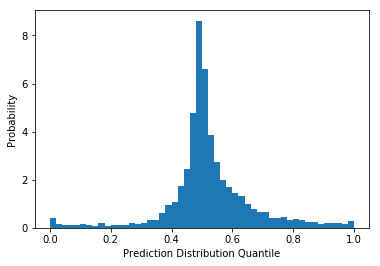

In [17]:
p_values = [d.cdf(a) for d, a in zip(oj_fcast[oj_fcast.pred_dist], oj_fcast[oj_fcast.actual])]
plt.hist(p_values, normed=True, histtype='stepfilled', bins= 50)
plt.ylabel('Probability')
plt.xlabel('Prediction Distribution Quantile')

From this experiment it looks like the prediction intervals may be too narrow on this particular dataset.  That can happen some times for data with a lot of zeros in it.

## `MultiForecastDataFrame`

The `MultiForecastDataFrame` is a sub class of the `ForecastDataFrame` that can hold the outputs of more than one model.  One easy way to get a `MultiForecastDataFrame` is to use the `ForecasterUnion` function to evaluate many different forecasting models at once.  Here we will compare the results of a `Naive` model and our `SeasonalNaive` model from before.

In [18]:
naive_model = Naive(freq = oj_data.infer_freq())
forecaster_union = ForecasterUnion(
    forecaster_list=[('naive', naive_model), 
                     ('seasonal_naive', snaive_model)])
forecaster_union.fit(oj_data)
oj_multifcast = forecaster_union.predict(oj_test)
oj_multifcast.head()

PointForecast  \
WeekLastDay         store brand       ForecastOriginTime  ModelName                       
1991-11-06 23:59:59 83    dominicks   1991-10-30 23:59:59 naive                11008.00   
                                                          seasonal_naive       10944.00   
                          minute.maid 1991-10-30 23:59:59 naive                16640.00   
                                                          seasonal_naive        9344.00   
                          tropicana   1991-10-30 23:59:59 naive                 8000.00   

                                                                                                       DistributionForecast  \
WeekLastDay         store brand       ForecastOriginTime  ModelName                                                           
1991-11-06 23:59:59 83    dominicks   1991-10-30 23:59:59 naive           <scipy.stats._distn_infrastructure.rv_frozen o...   
                                                          seasonal_naive  <scipy.stats._distn_infrastructure.rv_frozen o...   
                          minute.maid 1991-10-30 23:59:59 naive           <scipy.stats._distn_infrastructure.rv_frozen o...   
                                                          seasonal_naive  <scipy.stats._distn_infrastructure.rv_frozen o...   
                          tropicana   1991-10-30 23:59:59 naive           <scipy.stats._distn_infrastructure.rv_frozen o...   

                                                                          Quantity  
WeekLastDay         store brand       ForecastOriginTime  ModelName                 
1991-11-06 23:59:59 83    dominicks   1991-10-30 23:59:59 naive               4480  
                                                          seasonal_naive      4480  
                          minute.maid 1991-10-30 23:59:59 naive              63808  
                                                          seasonal_naive     63808  
                          tropicana   1991-10-30 23:59:59 naive               5184

Once again, lets take a look at out new metadata.

In [19]:
print("{")
for m in oj_multifcast._metadata:
    print("    {0}: {1}".format(m, getattr(oj_multifcast, m)))
print("}")

{
    grain_colnames: ['store', 'brand']
    time_colname: WeekLastDay
    group_colnames: ['store', 'brand']
    origin_time_colname: ForecastOriginTime
    actual: Quantity
    pred_point: PointForecast
    pred_dist: DistributionForecast
    model_colnames: {'model_class': 'ModelName'}
}


There is just one new field this time.

### `model_colnames`

`model_colnames` is our first metadata field to contain a `dict` rather than a string or list.

* `model_colnames`: A standardized dictionary with at least one of two keys, `model_class` and `param_values`.
    * `model_class`: A string specifying the column name which contains the name of the forecasting model used to create the forecasts.
    * `param_values`: A string specifying the column name which contains the parameters of the model used to create the forecast.
    
By specifying these two columns we can compare results from the same model or from the same model with different parameters or both.  Below we show an example of how we would compare the MAPE of our two models.

In [20]:
oj_multifcast.calc_error('MAPE', by=oj_multifcast.model_colnames['model_class'])

,ModelName,MAPE
0,naive,103.57
1,seasonal_naive,118.15
